# TEAM NAME: Classification Predict
## Introduction
### Context
Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

### The challenge

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Hypothesis
* Provide an interpretation of the target variable
* List out the features on which our target variable might depend
* Give a view about the problem based on domain knowledge

### Data and Library Imports
Now we will import the libraries required to perform:
* language manipulation
* data import, manipulation and visualisation

In [11]:
# Library imports

# running experiments
from comet_ml import Experiment

# language manipulation
import nltk # toolkit for language processing
from nltk.corpus import stopwords # redundant words

# Data manipulation and visualisation
import numpy as np # mathematical processing
import pandas as pd # data manipulation
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt  # data visualisation
%matplotlib inline

# Text manipulation
import re # regular expression for text extraction
import string # for punctuation removal

# set plot style
sns.set()


Next we will import the `test` and `train` data provided. Thereafter we will inspect the first 5 rows of the train data to get an understanding of the data. 

In [2]:
# Data importation
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# first 5 rows of train data
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
# first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


#### Data Description
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

Class Description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Variable definitions
- sentiment: Sentiment of tweet
- message: Tweet body
- tweetid: Twitter unique id

Let's confirm that the sentiment values conform to the description above and next obtain a view of the data samples for each sentiment.

In [5]:
# identify the sentiment values
list(train.sentiment.unique())

[1, 2, 0, -1]

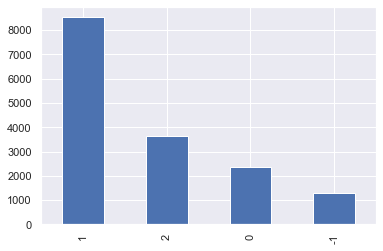

In [6]:
train['sentiment'].value_counts().plot(kind='bar')
plt.show()

From the bar graph above we discover that the majority of tweets are classified as pro the belief that climate change is man-made, followed by factual news, then neutral content and lastly tweets that show the believe that climate change is not man-made.

## Text Cleaning
Next we clean the message text to ensure that the data is in a usable format. First let's take a look at a message to see what kind of content we can expect to find. 

In [7]:
# Select the first tweet
train['message'].iloc[0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"

From the message above we observe that messages may contain web-urls, punctuation, upper and lower case characters.

### Removing Noise
Next we will remove unneccesary information, as seen above. These include web-urls, punctuation and stop-words. We will also convert the text to lower-case.

#### URL conversion

First we will replace website URLs with the text `url-web`

In [9]:
# Pattern to identify URLs
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
# Replacement text for URLs
subs_url = r'url-web'
# Replacement
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#### Punctuation removal
Next we will ensure text uniformity by converting all text to lower case and then removing punctuation.

In [13]:
# Message text to lower case
train['message'] = train['message'].str.lower()

# Removing punctuation
print('Punctuation to be removed:', string.punctuation)

Punctuation to be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [15]:
# Function to remove punctuation
def remove_punctuation(message):
    """Removes punctuation from tweets"""
    return ''.join([l for l in message if l not in string.punctuation])

In [16]:
# Apply the remove_punctuation function
train['message'] = train['message'].apply(remove_punctuation)

Let's take another look at the first message to see the effect of the text clean up.

In [18]:
# Select the first tweet
train['message'].iloc[0]

'polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable'

From the message above it's evident that all punctuation and unneccesary text has been removed. Next we will proceed with Feature Engineering.

### Feature Engineering

### Exploratory Data Analysis


##### Hypothesis validation

### Model building

### Model testing

### Model evaluation

In [ ]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="uSjPrOwXQdE1GLSEQuhuEJ1QQ",
    project_name="climate-change-sentiment",
    workspace="stanfordgibson",
)